In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

In [2]:
train_audio_path = '../input/train/audio/'
filename = '/yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

In [3]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


Text(0.5,0,'Seconds')

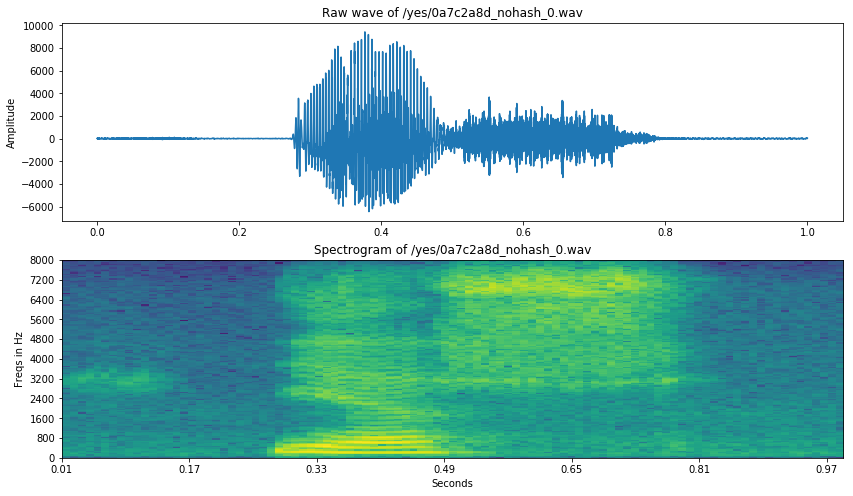

In [4]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')


In [5]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std


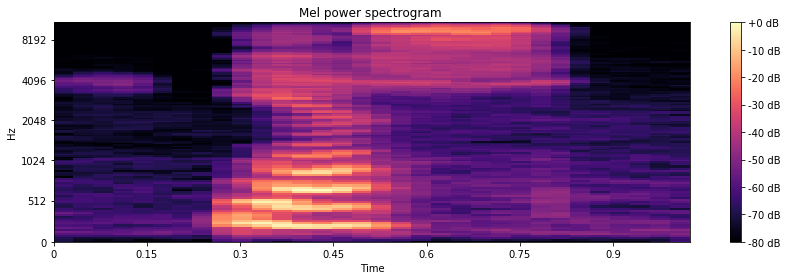

In [9]:
# From this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
S = librosa.feature.melspectrogram(samples.astype(float), sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

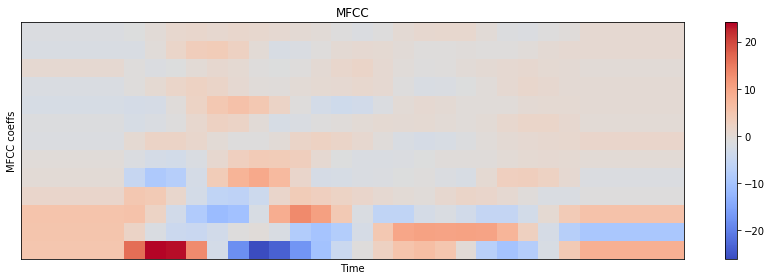

In [10]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [11]:
data = [go.Surface(z=spectrogram.T)]
layout = go.Layout(
    title='Specgtrogram of "yes" in 3d',
    scene = dict(
    yaxis = dict(title='Frequencies', range=freqs),
    xaxis = dict(title='Time', range=times),
    zaxis = dict(title='Log amplitude'),
    ),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)


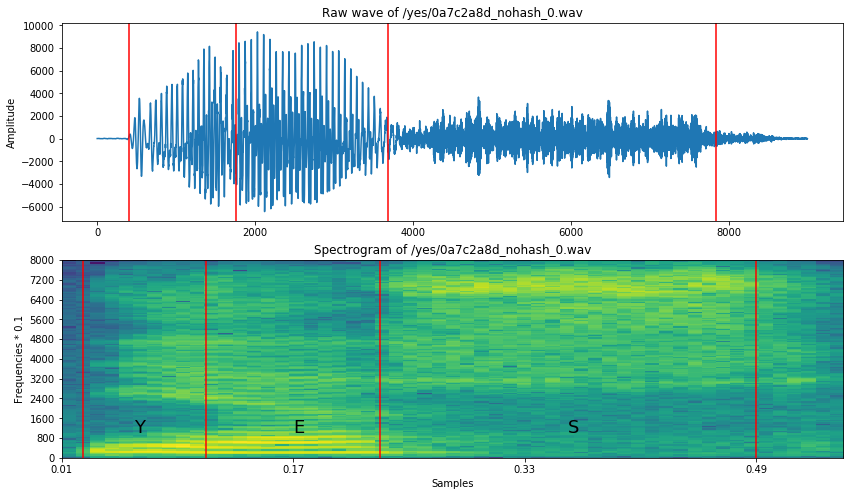

In [13]:
samples_cut = samples[4000:13000]

freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

In [14]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

In [16]:
filename = '/happy/0b09edd3_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

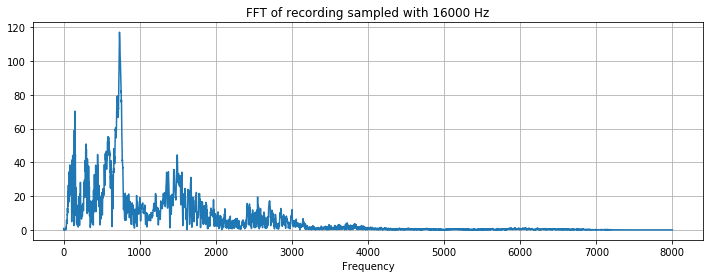

In [17]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

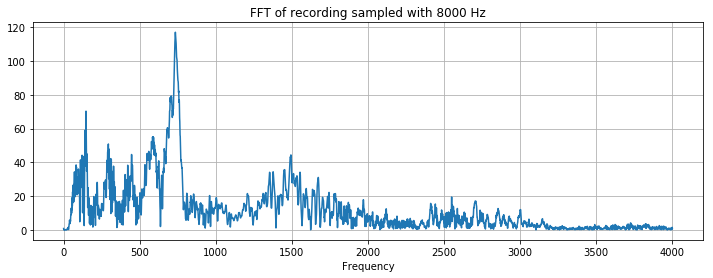

In [18]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

In [19]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

Number of labels: 31


In [20]:
# Calculate
number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

# Plot
data = [go.Histogram(x=dirs, y=number_of_recordings)]
trace = go.Bar(
    x=dirs,
    y=number_of_recordings,
    marker=dict(color = number_of_recordings, colorscale='Viridius', showscale=True
    ),
)
layout = go.Layout(
    title='Number of recordings in given label',
    xaxis = dict(title='Words'),
    yaxis = dict(title='Number of recordings')
)
py.iplot(go.Figure(data=[trace], layout=layout))

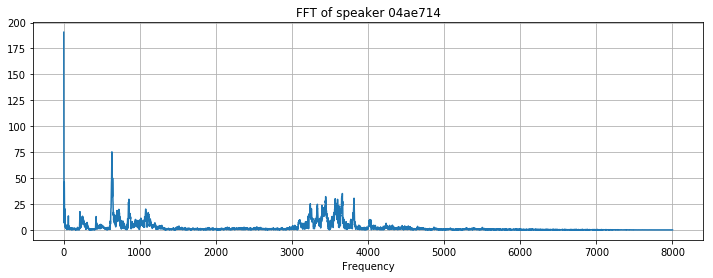

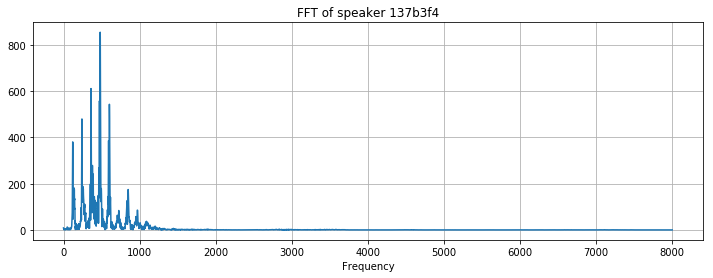

In [21]:
filenames = ['on/004ae714_nohash_0.wav', 'on/0137b3f4_nohash_0.wav']
for filename in filenames:
    sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of speaker ' + filename[4:11])
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

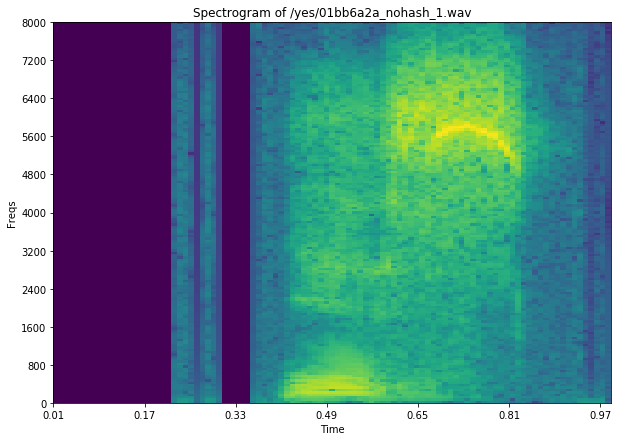

In [22]:
filename = '/yes/01bb6a2a_nohash_1.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
freqs, times, spectrogram = log_specgram(samples, sample_rate)

plt.figure(figsize=(10, 7))
plt.title('Spectrogram of ' + filename)
plt.ylabel('Freqs')
plt.xlabel('Time')
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.show()

In [23]:
num_of_shorter = 0
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] < sample_rate:
            num_of_shorter += 1
print('Number of recordings shorter than 1 second: ' + str(num_of_shorter))

/home/ser/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.



Number of recordings shorter than 1 second: 6469
